1. hyper parameter tuning with constraing output weights, linear layer weights normalization, batch norm
2. examine linear layer grad histogram, tanh layer input weights histogram
3. examine backpropagation grads in each layer

design:
an mlp with 5 hidden layers
input -> embedding
-> linear 1 -> tanh
-> linear 2 -> tanh
-> linear 3 -> tanh
-> linear 4 -> tanh
-> linear 5 -> output layer


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import random

In [3]:
''' model
input                               batch_size x block_size
-> embedding                        batch_size x block_size x embedding_size
-> linear 1 -> tanh                 batch_size x hidden_size
-> linear 2 -> tanh                 batch_size x hidden_size
-> linear 3 -> tanh                 batch_size x hidden_size
-> linear 4 -> tanh                 batch_size x hidden_size
-> linear 5 -> output layer         batch_size x vocab_size
'''
# hyper parameters
vocab_size = 27
embedding_size = 10
block_size = 3
hidden_size = 100
model_size = block_size * embedding_size

class Mudule():
  def __init__(self):
    pass
  def __call__(self, *args, **kwargs):
    print(self.__class__.__name__,self.out.requires_grad)
  def parameters(self):
    pass
  def __repr__(self):
    pass

class Embedding():
  def __init__(self, vocab_size, embedding_size, model_size):
    self.vocab_size = vocab_size
    self.embedding_size = embedding_size
    self.model_size = model_size
    self.w = torch.randn((vocab_size, embedding_size))

  def __call__(self, x):
    self.out = self.w[x].view(-1, self.model_size)
    return self.out

  def parameters(self):
    return [self.w]

  def __repr__(self):
    return f"Embedding(vocab_size={self.vocab_size}, embedding_size={self.embedding_size}, model_size={self.model_size})"

class Linear():
  def __init__(self, in_feature, out_feature, bias=True):
    self.in_feature = in_feature
    self.out_feature = out_feature
    self.bias = bias
    self.w  = torch.randn((in_feature, out_feature)) / in_feature ** 0.5
    self.b = torch.randn(out_feature) if bias else None

  def __call__(self, x):
    self.out = x @ self.w
    if self.b is not None:
      self.out += self.b
    return self.out

  def parameters(self):
    return [self.w, self.b] if self.b is not None else [self.w]

  def __repr__(self):
    return f"Linear(in_feature={self.in_feature}, out_feature={self.out_feature})"

class Tanh():
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

  def __repr__(self):
    return "Tanh()"

class Softmax():
  def __init__(self, dim=1):
    self.dim = dim

  def __call__(self, x):
      self.out = F.softmax(x, dim=self.dim)
      return self.out

  def parameters(self):
      return []

  def __repr__(self):
    return "Softmax()"


class CrossEntropyLoss():
  def __init__(self):
    self.logits = None
    self.targets = None

  def __call__(self, logits, targets):
    self.logits = logits
    self.targets = targets
    self.out = F.cross_entropy(logits, targets)
    return self.out

  def __repr__(self):
    return "CrossEntropyLoss()"

  def parameters(self):
    return []

layers = [
    Embedding(vocab_size, embedding_size, model_size),
    Linear(model_size, hidden_size),
    Tanh(),
    Linear(hidden_size, hidden_size),
    Tanh(),
    Linear(hidden_size, hidden_size),
    Tanh(),
    Linear(hidden_size, hidden_size),
    Tanh(),
    Linear(hidden_size, vocab_size),
]

inference_head = Softmax()
loss_head = CrossEntropyLoss()

def parameters():
  params = []
  for layer in layers:
    params += (layer.parameters())
  return params

def zero_grad():
  for p in parameters():
    p.grad = None
  for layer in layers:
    if hasattr(layer, 'out'):
      layer.out.grad = None
  if hasattr(inference_head, 'out'):
    inference_head.out = None
  if hasattr(loss_head, 'out'):
    loss_head.out = None

def requires_grad():
  for p in parameters():
    p.requires_grad = True

def retain_grad():
  for layer in layers:
    layer.out.retain_grad()
  #if inference_head.out is not None:
  #  inference_head.out.retain_grad()
  #if loss_head.out is not None:
  #  loss_head.out.retain_grad()

def no_grad():
  for p in parameters():
    p.requires_grad = False

def forward(x, y=None):
  for layer in layers:
    x = layer(x)

  if y is None:
    return inference_head(x)
  else:
    return loss_head(x, y)

print('------ model topology -----')
for layer in layers:
  print(layer, f'#params={sum(p.nelement() for p in layer.parameters())}')


------ model topology -----
Embedding(vocab_size=27, embedding_size=10, model_size=30) #params=270
Linear(in_feature=30, out_feature=100) #params=3100
Tanh() #params=0
Linear(in_feature=100, out_feature=100) #params=10100
Tanh() #params=0
Linear(in_feature=100, out_feature=100) #params=10100
Tanh() #params=0
Linear(in_feature=100, out_feature=100) #params=10100
Tanh() #params=0
Linear(in_feature=100, out_feature=27) #params=2727


In [ ]:
''' test model '''
print('------ inference ---------')
with torch.no_grad():
  print([torch.multinomial(probs, 1).item()
    for probs in forward(torch.tensor([[1,2,3],[0,1,0]]))])

  print(forward(torch.tensor([[0,2,3],[2,2,2]]),
                torch.tensor([0,1])))

requires_grad()

loss = forward(torch.tensor([[0,2,3],[2,2,2]]),
                torch.tensor([0,1]))
zero_grad()
retain_grad()
loss.backward()
#[print(p.__class__.__name__,p.grad.shape) for p in parameters()]
#[print(layer.__class__.__name__, layer.out.grad.shape) for layer in layers]
#print('done')

------ inference ---------
[21, 4]
tensor(3.8627)


In [4]:
requires_grad()
loss = forward(trainX, trainY)
retain_grad()
loss.backward()
print(f'loss: {loss.item():.4f}')

# tanh layer out
plt.figure(figsize=(16,12))
for layer in layers:
  if isinstance(layer,Tanh):
    hist, bins = layer.out.histogram(100)
    print(f'tanh layer out mean: {layer.out.grad.mean().item()}, std:{layer.out.grad.std().item()}')
    plt.subplot(331)
    plt.plot(bins[:-1].detach(), hist.detach(), label = f'{layer}')
plt.title('Tanh layer out')
plt.legend()

# tanh layer out grad
for layer in layers:
  if isinstance(layer,Tanh):
    hist, bins = layer.out.grad.histogram(100)
    plt.subplot(332)
    plt.plot(bins[:-1].detach(), hist.detach(), label = f'{layer}')
plt.title('Tanh layer out grad')
plt.legend()

# linear layer out
for layer in layers:
  if isinstance(layer,Linear):
    plt.subplot(334)
    hist_out, bins_out = layer.out.histogram(100)
    plt.plot(bins_out[:-1].detach(), hist_out.detach(), label = f'out of {layer}')
plt.title('Linear layer out')
plt.legend()

# linear layer out grad
for layer in layers:
  if isinstance(layer,Linear):
    hist, bins = layer.out.grad.histogram(100)
    print(f'linear layer grad mean: {layer.out.grad.mean().item()}, std:{layer.out.grad.std().item()}'
          f', grad/data ratio {layer.out.grad.mean() / layer.out.mean()}')
    plt.subplot(335)
    plt.plot(bins[:-1].detach(), hist.detach(), label = f'out grad of {layer}')
plt.title('Linear layer out grad')
plt.legend()

# Linear layer w
for layer in layers:
  if isinstance(layer,Linear):
    hist, bins = layer.w.histogram(100)
    plt.subplot(333)
    plt.plot(bins[:-1].detach(), hist.detach(), label = f'{layer}')
plt.title('Linear layer weight')
plt.legend()

# Linear layer w grad
for layer in layers:
  if isinstance(layer,Linear):
    hist, bins = layer.w.grad.histogram(100)
    plt.subplot(336)
    plt.plot(bins[:-1].detach(), hist.detach(), label = f'{layer}')
plt.title('Linear layer weight grad')
plt.legend()

# accuracy
with torch.no_grad():
  print(f'train accuracy: {forward(trainX, trainY).item():.4f}')
  print(f'validation accuracy: {forward(validationX, validationY).item():.4f}')
  print(f'test accuracy: {forward(testX, testY).item():.4f}')
  print(f'accuracy: {(forward(trainX).argmax(1) == trainY).sum() / trainY.shape[0]}')

plt.subplot(337)
plt.plot(losses)
plt.title('losses')

plt.subplot(338)
plt.imshow(layers[0].w.detach().T)
plt.title('embedding');

NameError: name 'trainX' is not defined

In [5]:
# load dataset
#words = ['emma', 'alice']
words = open('names.txt').read().splitlines()
words = [''.join(ch if ch>='a' and ch<='z' else '' for ch in word.lower()) for word in words]
alphabet = sorted(list(set(ch for word in words for ch in word)))
stoi = {ch:i+1 for i,ch in enumerate(alphabet)}
stoi['.'] = 0
itos = {i:ch for ch,i in stoi.items()}

vocab_size = len(stoi)
block_size = 3

dataX,dataY = [],[]
for word in words:
  full_word = '.' * block_size + word + '.'
  for si in range(len(word) + 1):
    dataX.append(full_word[si:si+block_size])
    dataY.append(full_word[si+block_size])

dataX = torch.tensor([[stoi[ch] for ch in word] for word in dataX])
dataY = torch.tensor([stoi[ch] for ch in dataY])

# shuffle dataset
permute_idxes = torch.randperm(len(dataX))
dataX, dataY = dataX[permute_idxes], dataY[permute_idxes]

# split dataset
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 1 - train_ratio - validation_ratio

train_size = int(len(dataX) * train_ratio)
validation_size = int(len(dataX) * validation_ratio)
test_size = len(dataX) - train_size - validation_size

trainX, trainY = dataX[:train_size], dataY[:train_size]
validationX, validationY = dataX[train_size:train_size+validation_size], dataY[train_size:train_size+validation_size]
testX, testY = dataX[train_size+validation_size:], dataY[train_size+validation_size:]

trainX.shape, trainY.shape, validationX.shape, validationY.shape, testX.shape, testY.shape

FileNotFoundError: [Errno 2] No such file or directory: 'names.txt'

epoch 0, loss 2.1903
epoch 1000, loss 2.1301
epoch 2000, loss 2.0683
epoch 3000, loss 1.9899
epoch 4000, loss 2.3472
epoch 5000, loss 2.0558
epoch 6000, loss 1.7197
epoch 7000, loss 2.4314
epoch 8000, loss 2.0507
epoch 9000, loss 2.0265


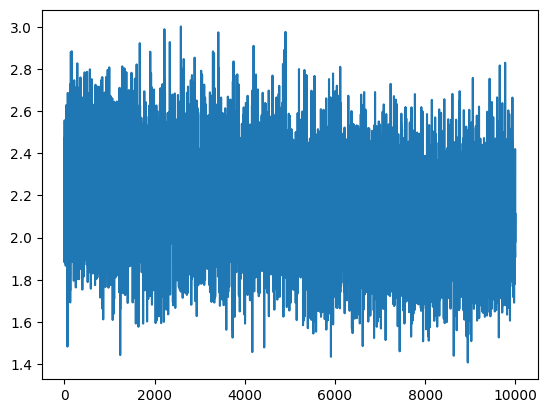

In [ ]:
# train model
num_epochs = 10000
batch_size = 32
def lr_schedule(epoch):
  return 0.1 if epoch < 5000 else 0.01

losses = []
for epoch in range(num_epochs):
  ix = torch.randint(0,trainX.shape[0], (batch_size,))

  requires_grad()
  loss = forward(trainX[ix], trainY[ix])

  zero_grad()
  loss.backward()


  lr = lr_schedule(epoch)
  for p in parameters():
    p.data += -lr * p.grad

  losses.append(loss.item())

  if epoch % 1000 == 0:
    print(f'epoch {epoch}, loss {loss.item():.4f}')

plt.plot(losses)

In [ ]:
# eval
def eval():
  with torch.no_grad():
    print(f'train loss: {forward(trainX, trainY).item():.4f}')
    print(f'validation loss: {forward(validationX, validationY).item():.4f}')
eval()

train loss: 3.0103
validation loss: 3.0138


In [ ]:
# test
def generate():
  with torch.no_grad():
    out = []
    context = [0] * block_size
    while True:
      ch = torch.multinomial(forward(context)[0], 1, replacement=True).item()
      if ch == 0:
        break
      out.append(itos[ch])
      context = context[1:] + [ch]
    return ''.join(out)

for _ in range(10):
  print(generate())

ridalsa
sabeth
old
trif
dori
shinch
merlailah
macy
ore
emmathing
